In [1]:
from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import autograd.scipy.stats.norm as norm
from autograd.scipy.stats import multivariate_normal
import numpy
import math
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sys

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

In [3]:
def lognormexp(values, dim=0):
    """Exponentiates, normalizes and takes log of a tensor.
    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n
    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                                 exp(values[i_1, ..., i_N])
            log( ------------------------------------------------------------ )
                    sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    log_denominator = sp.special.logsumexp(values, axis=dim, keepdims=True)
    # log_numerator = values
    return values - log_denominator

def exponentiate_and_normalize(values, dim=0):
    """Exponentiates and normalizes a tensor.
    Args:
        values: tensor [dim_1, ..., dim_N]
        dim: n
    Returns:
        result: tensor [dim_1, ..., dim_N]
            where result[i_1, ..., i_N] =
                            exp(values[i_1, ..., i_N])
            ------------------------------------------------------------
             sum_{j = 1}^{dim_n} exp(values[i_1, ..., j, ..., i_N])
    """

    return np.exp(lognormexp(values, dim=dim))

def get_thermo_loss_from_log_weight_log_p_log_q(log_weight, log_p, log_q, partition, num_particles=1,
                                                integration='left'):
    """Args:
        log_weight: tensor of shape [batch_size, num_particles]
        log_p: tensor of shape [batch_size, num_particles]
        log_q: tensor of shape [batch_size, num_particles]
        partition: partition of [0, 1];
            tensor of shape [num_partitions + 1] where partition[0] is zero and
            partition[-1] is one;
            see https://en.wikipedia.org/wiki/Partition_of_an_interval
        num_particles: int
        integration: left, right or trapz
    Returns:
        loss: scalar that we call .backward() on and step the optimizer.
        elbo: average elbo over data
    """

    partition = np.array(partition)
    heated_log_weight = np.expand_dims(log_weight, axis=log_weight.ndim) * partition
    heated_normalized_weight = exponentiate_and_normalize(
        heated_log_weight, dim=1)
    thermo_logp = partition * np.expand_dims(log_p, axis=log_p.ndim) + \
        (1 - partition) * np.expand_dims(log_q, axis=log_q.ndim)

    wf = heated_normalized_weight * np.expand_dims(log_weight, axis=log_weight.ndim)
    w_detached = np.array(heated_normalized_weight)
    wf_detached = np.array(wf)
    if num_particles == 1:
        correction = 1
    else:
        correction = num_particles / (num_particles - 1)

    cov = correction * np.sum(
        w_detached * np.array(np.expand_dims(log_weight, axis=log_weight.ndim) - np.sum(wf, axis=1, keepdims=True)) *
        (thermo_logp - np.sum(thermo_logp * w_detached, axis=1, keepdims=True)),
        axis=1)

    multiplier = np.zeros_like(partition)
    if integration == 'trapz':
        multiplier[0] = 0.5 * (partition[1] - partition[0])
        multiplier[1:-1] = 0.5 * (partition[2:] - partition[0:-2])
        multiplier[-1] = 0.5 * (partition[-1] - partition[-2])
    elif integration == 'left':
        multiplier[:-1] = partition[1:] - partition[:-1]
    elif integration == 'right':
        multiplier[1:] = partition[1:] - partition[:-1]

    loss = -np.mean(np.sum(
        multiplier * (cov + np.sum(
            w_detached * np.expand_dims(log_weight, axis=log_weight.ndim), axis=1)),
        axis=1))

    return loss

In [4]:
class VAE:
    def __init__(self, decoder_architecture, encoder_architecture, x_var, random=None, decoder_weights=None, encoder_weights=None):
        '''constructor'''
        self.x_dim = decoder_architecture['output_dim']
        self.z_dim = decoder_architecture['input_dim']

        self.x_var = x_var

        assert encoder_architecture['input_dim'] == self.x_dim
        assert encoder_architecture['output_dim'] == self.z_dim * 2

        self.decoder = Feedforward(decoder_architecture, random=random, weights=decoder_weights)
        self.encoder = Feedforward(encoder_architecture, random=random, weights=encoder_weights)

        self.objective_trace = np.empty((1, 1))
        self.param_trace = np.empty((1, self.decoder.D + self.encoder.D))
        self.S = 10

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)
            
    def generate(self, weights=None, N=100):
        '''use the generative model to generate x given zs sampled from the prior'''
        z_samples = self.random.normal(0, 1, size=(self.z_dim, N))

        if weights is None:
            x_samples = self.decoder.forward(self.decoder.weights, z_samples)
        else:
            x_samples = self.decoder.forward(weights, z_samples)
            
        return x_samples[0]

    def infer(self, x, weights=None):
        '''use the inference model to infer parameters of q(z|x)'''
        if weights is None:
            z = self.encoder.forward(self.encoder.weights, x)
        else:
            z = self.encoder.forward(weights, x)
            
        return z[0]
    
    def unpack_params(self, z_params):
        '''unpack variational parameters for q(z|x)'''
        assert len(z_params.shape) == 2
        assert z_params.shape[0] == 2 * self.z_dim

        mean, parametrized_var = z_params[:self.z_dim], z_params[self.z_dim:]
        std = np.exp(parametrized_var)

        return mean, std
    
    def unpack_weights(self, params):
        '''unpack the weights for the encoder and decoder'''
        assert len(params.shape) == 2
        assert params.shape[1] == self.encoder.D + self.decoder.D
        
        decoder_weights = params[:, :self.decoder.D].reshape((1, -1))
        encoder_weights = params[:, self.decoder.D:].reshape((1, -1))
        
        return encoder_weights, decoder_weights
    
    def make_objective(self, x_train, S):
        '''make variational objective function and gradient of the variational objective'''
        assert len(x_train.shape) == 2
        assert x_train.shape[0] == self.x_dim
        

        if S is not None:
            self.S = S

        N = x_train.shape[1]
        x_dummy = np.zeros((self.S, self.x_dim, N))

           
        def variational_objective(params, t, partition=[0,0.25,0.5,0.75,1], integration='left'):
            '''definition of the ELBO'''
            encoder_weights, decoder_weights = self.unpack_weights(params)

            #infer z's
            z_params = self.encoder.forward(encoder_weights, x_train)[0]
            
            #unpack var parameters
            mean, std = self.unpack_params(z_params)
            assert std.shape == (self.z_dim, N)
            assert mean.shape == (self.z_dim, N)
            
            #sample z's
            z_samples = np.random.normal(0, 1, size=(self.S, self.z_dim, N)) * std + mean
            assert z_samples.shape == (self.S, self.z_dim, N)
            
            #predict x's
            x = self.decoder.forward(decoder_weights, z_samples)
            assert x.shape == (self.S, self.x_dim, N)
            
            #evaluate log-likelihood
            log_likelihood = np.sum(norm.logpdf(x_train, x, self.x_var ** 0.5), axis=-2)
            assert log_likelihood.shape == (self.S, N)
                        
            #evaluate sampled z's under prior
            log_pz = np.sum(norm.logpdf(z_samples, 0.0, 1.0), axis=-2)
            assert log_pz.shape == (self.S, N)
            
            #evaluate sampled z's under variational distribution
            log_qz_given_x = np.sum(norm.logpdf(z_samples, mean, std), axis=-2)
            assert log_qz_given_x.shape == (self.S, N)
            
            log_p = log_pz
            log_q = log_qz_given_x
            log_weight = log_p - log_q
            
            return get_thermo_loss_from_log_weight_log_p_log_q(log_weight, log_p, log_q, [0,0.25,0.5,0.75,1], num_particles=1,integration='left')
            
#             #compute the elbo
#             elbo = np.mean(log_likelihood - log_qz_given_x + log_pz)
            
#             #return the negative elbo to be minimized
#             return -elbo
            
            
        return variational_objective, grad(variational_objective)
    
                          
    def fit(self, x_train, S=None, params=None):
        '''minimize -ELBO'''
        assert x_train.shape[0] == self.x_dim

        ### make objective function for training
        objective, gradient = self.make_objective(x_train, S)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        param_init = self.random.normal(0, 0.3, size=(1, self.decoder.D + self.encoder.D))
        mass = None
        optimizer = 'adam'
        random_restarts = 1

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            check_point = params['check_point']
        if 'init' in params.keys():
            param_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(params, iteration, g):
            ''' Actions per optimization step '''
            objective_val = objective(params, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective_val))
            self.param_trace = np.vstack((self.param_trace, params))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_val, np.linalg.norm(gradient(params, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_param = param_init

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(gradient, param_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[1:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[1:])
                opt_params = self.param_trace[1:][opt_index].reshape((1, -1))
                self.opt_params = opt_params
                encoder_weights, decoder_weights = self.unpack_weights(opt_params)
                self.decoder.weights = decoder_weights
                self.encoder.weights = encoder_weights
                optimal_obj = local_opt

            param_init = self.random.normal(0, 0.1, size=(1, self.decoder.D + self.encoder.D))

        self.objective_trace = self.objective_trace[1:]
        self.param_trace = self.param_trace[1:]

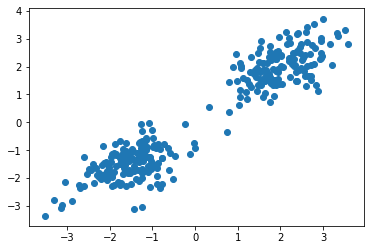

In [5]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

indices = numpy.random.randint(2, size=300)
samples = [numpy.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + numpy.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

In [6]:
#decoder architecture
input_dim = 2
output_dim = 2
width = 50
hidden_layers = 1
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn_type = 'linear'
# activation_fn = lambda x: x
decoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}


#encoder architecture
input_dim = 2
output_dim = 4
width = 50
hidden_layers = 1
# activation_fn_type = 'relu'
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)



encoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}

vae = VAE(decoder_architecture, encoder_architecture, x_var)

In [7]:
# x_train, _ = generate_data(N=200, var=x_var) 

params = {'step_size':5e-5,
      'max_iteration':1000,
      'random_restarts':1,
     }


vae.fit(x_train.T, params=params, S=50)

Iteration 0 lower bound 2.290741049975402; gradient mag: 5.5266499958235915
Iteration 100 lower bound 1.9490569997410325; gradient mag: 5.154875307462461
Iteration 200 lower bound 1.589936651423838; gradient mag: 5.200664362853371
Iteration 300 lower bound 1.324971967260316; gradient mag: 4.833708019999042
Iteration 400 lower bound 1.0659740646933484; gradient mag: 5.068309840524293
Iteration 500 lower bound 0.7392493302403338; gradient mag: 5.200715019765207
Iteration 600 lower bound 0.44771393399748; gradient mag: 5.054952189924461
Iteration 700 lower bound 0.13537056037459422; gradient mag: 5.089914425318304
Iteration 800 lower bound -0.2361271490155007; gradient mag: 5.717172846377993
Iteration 900 lower bound -0.6256174055387913; gradient mag: 5.99644063011851


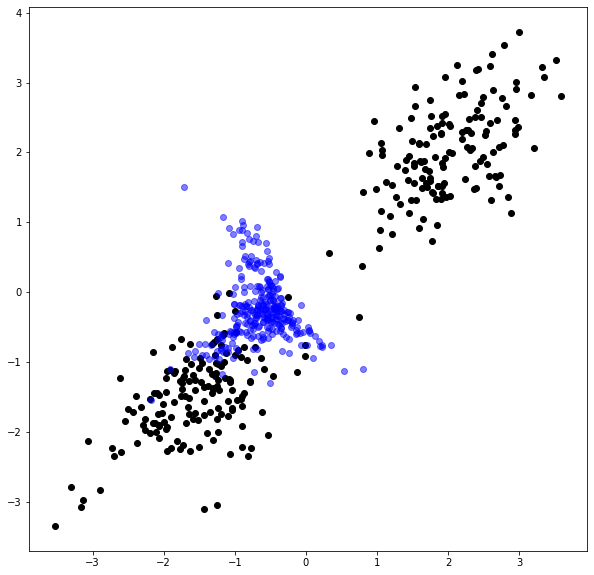

In [9]:
x_hat = vae.generate(N=300)
x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5)

plt.show()